In [1]:
%matplotlib inline

from tensorflow import keras
import tensorflow as tf
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib
import pylab as pl
from scipy.fftpack import rfft
import aifc
from IPython.display import Image
from PIL import Image
from keras.callbacks import ModelCheckpoint
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.font_manager import FontProperties

from keras.layers import Dense, Conv2D, Flatten, ConvLSTM2D, Input, Rescaling, LSTM, Concatenate, Dropout, GRU, Conv1D
from keras import Sequential

from sklearn.ensemble import RandomForestRegressor

Watch train data

In [2]:
df = pd.read_csv('../data/data/train.csv')
print(df.head(5))

     clip_name  label
0  train1.aiff      0
1  train2.aiff      0
2  train3.aiff      0
3  train4.aiff      0
4  train5.aiff      0


Let's try to plot a simple spectrogram

In [3]:
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]

    im = pl.imshow(Z, extent=extent)
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, 1000])

In [4]:
whale_sample_file = '../data/data/train/train1.aiff'
whale_aiff = aifc.open(whale_sample_file,'r')
print("Channels:", whale_aiff.getnchannels()) 
print("Frames:", whale_aiff.getnframes())
print("Frame rate (frames per second):", whale_aiff.getframerate())

Channels: 1
Frames: 4000
Frame rate (frames per second): 2000


/var/folders/xw/04yvk1hx1tg55kxcyvtbggcm0000gn/T/ipykernel_24472/726627918.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  whale_array = np.fromstring(whale_strSig, np.short).byteswap()


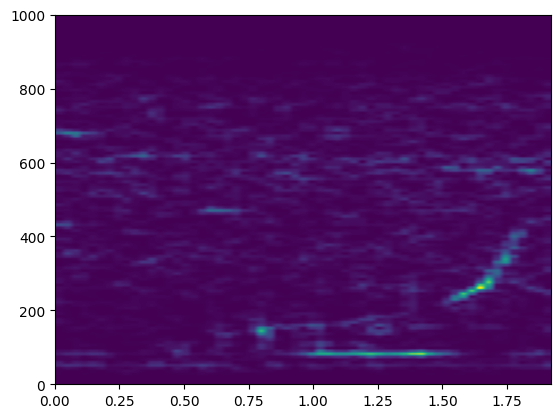

In [5]:
whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
whale_array = np.fromstring(whale_strSig, np.short).byteswap()
params = {'NFFT':256, 'Fs':2000, 'noverlap':192}
P, freqs, bins = mlab.specgram(whale_array, **params)
img = PlotSpecgram(P, freqs, bins)

Now we can plot and recognize others spectrograms and add a target for each of them

In [6]:
# Set path to directory with folders train and test
path_data = '../data/data/'
path_train_audio = '../data/data/train/'
path_target_train = '../data/data/train.csv'

In [7]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

Create datasets

In [18]:
# Set path to directory with folders train and test
df = pd.read_csv('../data/data/train.csv')
path_train_img = '../datasets/pngs_from_wavs/'
path_train_img_noised_1 = '../datasets/pngs_from_wavs_noised_002/'

train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)
test_index = val_index + int(len(df["clip_name"]) * 0.1)

def create_dataset(train_index, val_index, test_index):

    x_train = []
    y_train = []

    x_val = []
    y_val = []
    
    x_test = []
    y_test = []
    for i in range(len(df["clip_name"])):
        FILENAME = path_train_img + df["clip_name"][i][:-5] + '.png'
        # FILENAME = path_train_img_noised_1 + df["clip_name"][i][:-5] + '.png'
        rgba_image = Image.open(FILENAME)
        img = rgba_image.convert('RGB')
        img_arr = np.asarray(img)
        rgba_image.close()
        #print(FILENAME)

        if i < train_index:
            x_train.append(img_arr)
            y_train.append(df["label"][i])
        elif i < val_index:
            x_val.append(img_arr)
            y_val.append(df["label"][i])
        else:
            x_test.append(img_arr)
            y_test.append(df["label"][i])
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

In [19]:
x_train, y_train, x_val, y_val, x_test, y_test = create_dataset(train_index, val_index, test_index)

In [20]:
batch_size = 32

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().batch(batch_size).prefetch(buffer_size=100)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size).prefetch(buffer_size=100)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size).prefetch(buffer_size=100)

Create train dataset

- train : 80%
- val : 10%
- test : 10%

In [21]:
x_train.shape

(24000, 146, 139, 3)

Link for NN model Xception

In [12]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

### Xception

In [13]:
# https://keras.io/guides/transfer_learning/

Xception_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(146, 139, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [50]:
# Freeze the base_model
Xception_model.trainable = False

In [14]:
inputs = keras.Input(shape=(146, 139, 3))
x = inputs
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

In [15]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = Xception_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(200)(x)
outputs = keras.layers.Dense(1)(x)
model_x = keras.Model(inputs, outputs)

model_x.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 146, 139, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 146, 139, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 200)               409800    
                                                             

In [59]:
weights_file_x = '../weights_xception/xception_weights_1.h5'
model_x.load_weights(weights_file_x)

callback_x = ModelCheckpoint(weights_file_x, mode='max', save_best_only=True)

model_x.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

# epochs = 1
# history_x1 = model_x.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[callback_x])
# history_x1 = model_x.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[callback_x])

In [16]:
weights_file_x2 = '../weights_xception/xception_weights_2.h5'
callback_x2 = ModelCheckpoint(weights_file_x2, mode='max', save_best_only=True)
model_x.load_weights(weights_file_x2)

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
Xception_model.trainable = True


model_x.summary()

model_x.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

# epochs = 1
# history_x2 = model_x.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[callback_x2])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 146, 139, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 146, 139, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 200)               409800    
                                                             

If we want to use model with trained weights

In [17]:
weights_file_x = '../weights_xception/xception_weights_2.h5'
model_x.load_weights(weights_file_x)
model_x.trainable = False

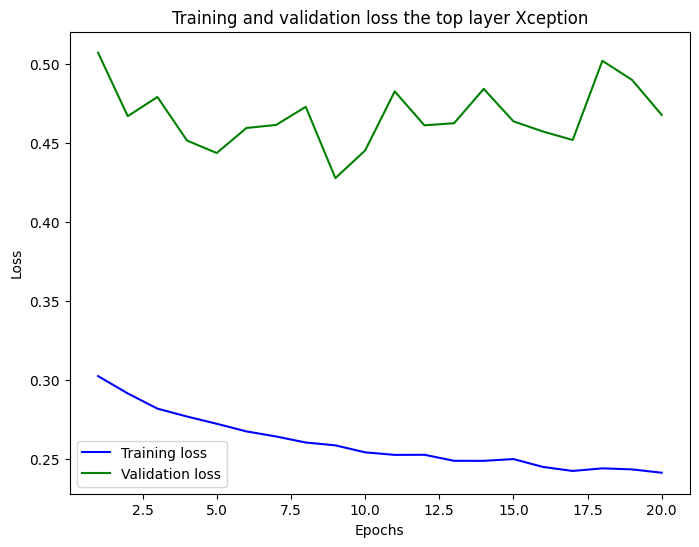

In [57]:
loss = history_x1.history['loss']
val_loss = history_x1.history['val_loss']
epochs = range(1, len(loss) + 1)

pdf = PdfPages("../images/loss_x1.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss the top layer Xception')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

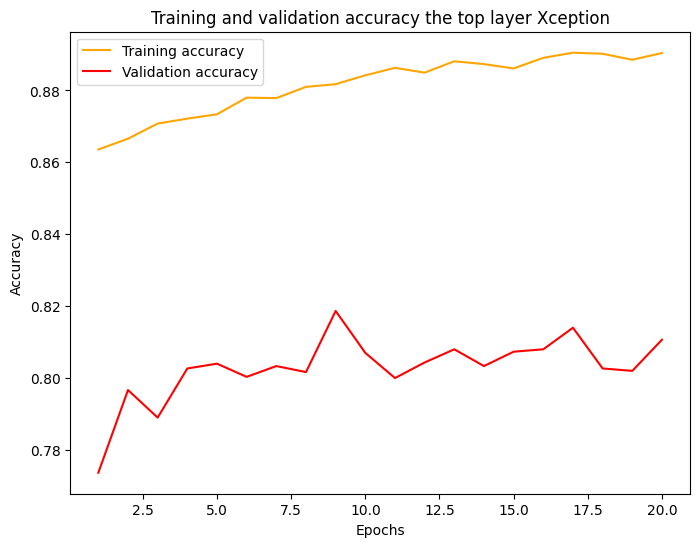

In [58]:
loss = history_x1.history['binary_accuracy']
val_loss = history_x1.history['val_binary_accuracy']
epochs = range(1, len(loss) + 1)

pdf = PdfPages("../images/accuracy_x1.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(epochs, loss, color = 'orange', label='Training accuracy')
ax.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy the top layer Xception')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

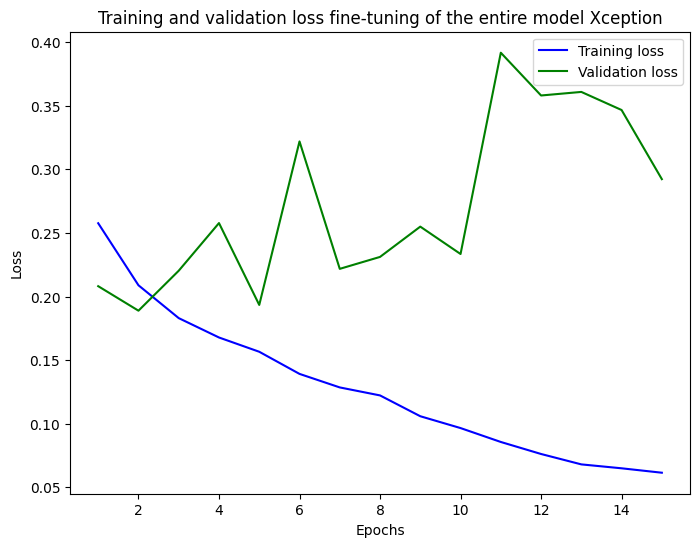

In [59]:
loss = history_x2.history['loss']
val_loss = history_x2.history['val_loss']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/loss_x2.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss fine-tuning of the entire model Xception')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

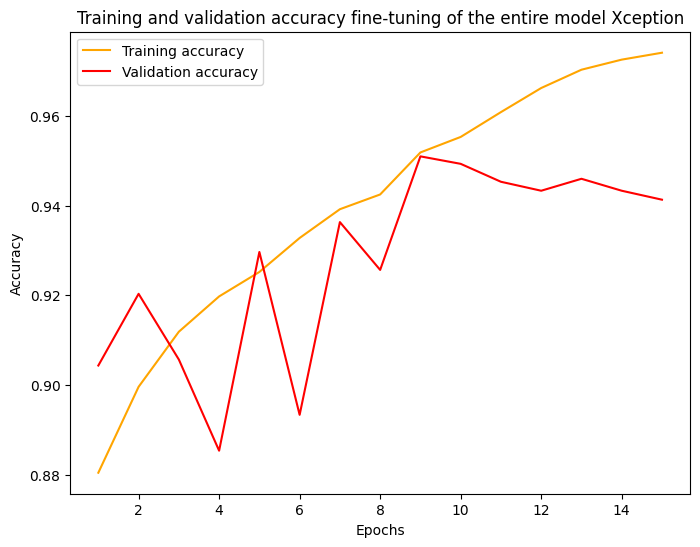

In [60]:
loss = history_x2.history['binary_accuracy']
val_loss = history_x2.history['val_binary_accuracy']
epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'g', label='Validation loss')
# # plt.title('Training and validation loss')
# # plt.ylim(0, 0.3)
# plt.legend()
# plt.show()

pdf = PdfPages("../images/accuracy_x2.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, color = 'orange', label='Training accuracy')
ax.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy fine-tuning of the entire model Xception')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend()
pdf.savefig(fig)
pdf.close()
plt.show()

Accuracy with trained weights is 97%. With noised data - 89.26%

In [22]:
score_x = model_x.evaluate(test_data, verbose=0)
print("Xception test loss:", score_x[0])
print("Xception test accuracy:", score_x[1])

2023-03-24 12:11:51.081643: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Xception test loss: 0.20475991070270538
Xception test accuracy: 0.9733333587646484


## New NN

In [51]:
# Set path to directory with folders train and test
df = pd.read_csv('../data/data/train.csv')
path_train_img = '../datasets/pngs_from_wavs/'
path_train_img_noised_1 = '../datasets/pngs_from_wavs_noised_002/'

train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)
test_index = val_index + int(len(df["clip_name"]) * 0.1)

def create_dataset(train_index, val_index, test_index):

    x_train = []
    y_train = []

    x_val = []
    y_val = []
    
    x_test = []
    y_test = []
    for i in range(len(df["clip_name"])):
        # FILENAME = path_train_img + df["clip_name"][i][:-5] + '.png'
        FILENAME = path_train_img_noised_1 + df["clip_name"][i][:-5] + '.png'
        rgba_image = Image.open(FILENAME)
        img = rgba_image.convert('RGB')
        img_arr = np.asarray(img)
        rgba_image.close()
        #print(FILENAME)

        if i < train_index:
            x_train.append(img_arr)
            # if df["label"][i] == 1:
            #     y_train.append(100) # whale
            # else:
            #     y_train.append(-100) # not whale
            y_train.append(df["label"][i])
        elif i < val_index:
            x_val.append(img_arr)
            # if df["label"][i] == 1:
            #     y_val.append(100) # whale
            # else:
            #     y_val.append(-100) # not whale
            y_val.append(df["label"][i])
        else:
            x_test.append(img_arr)
            # if df["label"][i] == 1:
            #     y_test.append(100) # whale
            # else:
            #     y_test.append(-100) # not whale
            y_test.append(df["label"][i])
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

In [52]:
batch_size = 32

x_train_img, y_train_img, x_val_img, y_val_img, x_test_img, y_test_img = create_dataset(train_index, val_index, test_index)

train_data = tf.data.Dataset.from_tensor_slices((x_train_img, y_train_img))
train_data = train_data.shuffle(120, reshuffle_each_iteration=True).batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((x_test_img, y_test_img))
test_data = test_data.batch(batch_size)

In [ ]:
x_test_img.shape

(3000, 146, 139, 3)

In [54]:
# NEW FUNCTION FOR MAKING H/C TRAIN AND TEST FROM WAVS

from scipy.spatial.distance import jensenshannon
import librosa

def compute_spectral_info(spectrum):
    N = len(spectrum)
        
    H_p = 0
    H_q = 0
    Complexity_sq = 0
    Complexity_jen = 0
    Complexity_abs = 0
    
    yf = spectrum
        
    Sum = sum(yf) 
    square_sum = 0
    abs_sum = 0

    p_is = []
    for s in yf:
        
        p_i = s/Sum
        if (p_i > 0): 
            p_is.append(p_i)
            H_p += -p_i*np.log2(p_i)
        
    Nfft = len(p_is)
    q_i = 1.0/Nfft # Noise spectrum

    for k in range(Nfft):
        square_sum += (p_is[k] - q_i)**2
        abs_sum += np.abs(p_is[k] - q_i)

    Disequilibrium_sq = square_sum


    H_p /= np.log2(Nfft)

    Jensen = jensenshannon(p_is, [q_i for j in range(Nfft)])

    Q0 = -2.0/((Nfft+1)*np.log2(Nfft+1)/Nfft - 2*np.log2(2*Nfft)+np.log2(Nfft))
    
    Disequilibrium_jen = (Jensen**2)*Q0
    
    Complexity_sq = H_p*square_sum
    
    Complexity_jen = H_p*Disequilibrium_jen #H_p*square_sum#H_p*(Jensen**2)*Q0##H_p*square_sum##np.exp(H_p)*square_sum # H_p*(0.5*square_sum*len(p_is) - 1.0*third_sum*(len(p_is)**2)/6)# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 
    
    Complexity_abs += H_p*(abs_sum**2)/4

    return H_p, Complexity_sq, Complexity_jen, Complexity_abs

df = pd.read_csv('../data/data/train.csv')
path_train = '../datasets/train_wav/'
path_train_noised_1 = '../datasets/train_wavs_noised_002/'

train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)
test_index = val_index + int(len(df["clip_name"]) * 0.1)

def create_HC_dataset_wavs(train_index, val_index, test_index):

    x_train = []
    y_train = []

    x_val = []
    y_val = []
    
    x_test = []
    y_test = []
    
    for i in range(len(df["clip_name"])):
        # FILENAME = path_train + df["clip_name"][i][:-5] + '.wav'
        FILENAME = path_train_noised_1 + 'noised_002_' + df["clip_name"][i][:-5] + '.wav'
        
        H_s = []
        C_sqs = []
        C_jsds = []
        
        y, sr = librosa.load(FILENAME, sr=None)
        WINDOW_FFT = 256
        WINDOW_HOP = 32

        D = librosa.stft(y, hop_length = WINDOW_HOP, n_fft = WINDOW_FFT, window = 'hamming')  # STFT of y
        # S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) #to decibels
        S_db = np.abs(D)
        for j in range(126):
            local_spect = S_db[:, j]
            H, C_sq, C_jsd, C_tv = compute_spectral_info(local_spect)
            H_s.append(H)
            C_sqs.append(C_sq)
            C_jsds.append(C_jsd)
            
        hc_plane = ((H_s, C_sqs, C_jsds))
        #print(FILENAME)

        if i < train_index:
            x_train.append(hc_plane)
            # if df["label"][i] == 1:
            #     y_train.append((1, 0)) # whale
            # else:
            #     y_train.append((0, 1)) # not whale
            y_train.append(df["label"][i])
        elif i < val_index:
            x_val.append(hc_plane)
            # if df["label"][i] == 1:
            #     y_val.append((1, 0)) # whale
            # else:
            #     y_val.append((0, 1)) # not whale
            y_val.append(df["label"][i])
        else:
            x_test.append(hc_plane)
            # if df["label"][i] == 1:
            #     y_test.append((1, 0)) # whale
            # else:
            #     y_test.append((0, 1)) # not whale
            y_test.append(df["label"][i])
    
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)

Datasets could be created by the previous function

In [55]:
df = pd.read_csv('../data/data/train.csv')

train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)
test_index = val_index + int(len(df["clip_name"]) * 0.1)

x_train_hc, y_train_hc, x_val_hc, y_val_hc, x_test_hc, y_test_hc = create_HC_dataset_wavs(train_index, val_index, test_index)

In [56]:
# path_save_array = '../datasets/hc_arrays/'

# np.save(path_save_array + 'x_train_hc_n_2', x_train_hc)
# np.save(path_save_array + 'y_train_hc_n_2', y_train_hc)

# np.save(path_save_array + 'x_val_hc_n_2', x_val_hc)
# np.save(path_save_array + 'y_val_hc_n_2', y_val_hc)

# np.save(path_save_array + 'x_test_hc_n_2', x_test_hc)
# np.save(path_save_array + 'y_test_hc_n_2', y_test_hc)

Or loaded from numpy arrays files

In [22]:
# path_save_array = '../datasets/hc_arrays/'

# x_train_hc = np.load(path_save_array + 'x_train_hc.npy')
# y_train_hc = np.load(path_save_array + 'y_train_hc.npy')

# x_val_hc = np.load(path_save_array + 'x_val_hc.npy')
# y_val_hc = np.load(path_save_array + 'y_val_hc.npy')

# x_test_hc = np.load(path_save_array + 'x_test_hc.npy')
# y_test_hc = np.load(path_save_array + 'y_test_hc.npy')

In [57]:
def mean_data(data):
    mean = data[:].mean(axis=0)
    data -= mean
    std = data[:].std(axis=0)
    data /= std
    return data

def avg_images(data):
    return data[:] / 255.0

In [58]:
# x_train_img = avg_images(x_train_img)
# x_val_img = avg_images(x_val_img)
# x_test_img = avg_images(x_test_img)

x_train_hc = mean_data(x_train_hc)
x_val_hc = mean_data(x_val_hc)
x_test_hc = mean_data(x_test_hc)

In [ ]:
train_data_hc = tf.data.Dataset.from_tensor_slices((x_train_hc, y_train_hc))
val_data_hc = tf.data.Dataset.from_tensor_slices((x_val_hc, y_val_hc))
test_data_hc = tf.data.Dataset.from_tensor_slices((x_test_hc, y_test_hc))

batch_size = 32

train_data_hc = train_data_hc.batch(batch_size)
val_data_hc = val_data_hc.batch(batch_size)
test_data_hc = test_data_hc.batch(batch_size)

In [ ]:
x_train_img.shape

(24000, 146, 139, 3)

In [43]:
batch_size = 32
model_x.trainable = False

weights_file_big = '../weights_xception/great_weights.h5'
great_callback = ModelCheckpoint(weights_file_big, mode='max', save_best_only=True)

# cnn
image_input = Input(shape=(146, 139, 3))
image_output = model_x(image_input)

# rnn
series_input = Input(shape=x_train_hc.shape[-2:])
series_out = Conv1D(filters=256, kernel_size=10, activation='tanh', padding='same')(series_input)
series_out = Dropout(0.1)(series_out)
series_out = Conv1D(filters=128, kernel_size=10, activation='tanh', padding='same')(series_out)
series_out = Dropout(0.1)(series_out)
series_out = Conv1D(filters=64, kernel_size=10, activation='tanh', padding='same')(series_out)
series_out = Dropout(0.1)(series_out)
series_out = Flatten()(series_out)
series_out = Dense(1024, activation='tanh')(series_out)
series_out = Dropout(0.1)(series_out)
series_out = Dense(512, activation='tanh')(series_out)
series_out = Dropout(0.1)(series_out)
series_output = Dense(128, activation='tanh')(series_out)

# final nn
concat = Concatenate()([image_output, series_output])
out = Dense(64, activation='tanh')(concat)
out = Dropout(0.1)(out)
out = Dense(16, activation='tanh')(out)
output = Dense(1, activation='sigmoid')(out)

model = tf.keras.Model([image_input, series_input], output)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 3, 126)]     0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 3, 256)       322816      ['input_8[0][0]']                
                                                                                                  
 dropout_32 (Dropout)           (None, 3, 256)       0           ['conv1d_18[0][0]']              
                                                                                                  
 conv1d_19 (Conv1D)             (None, 3, 128)       327808      ['dropout_32[0][0]']             
                                                                                            

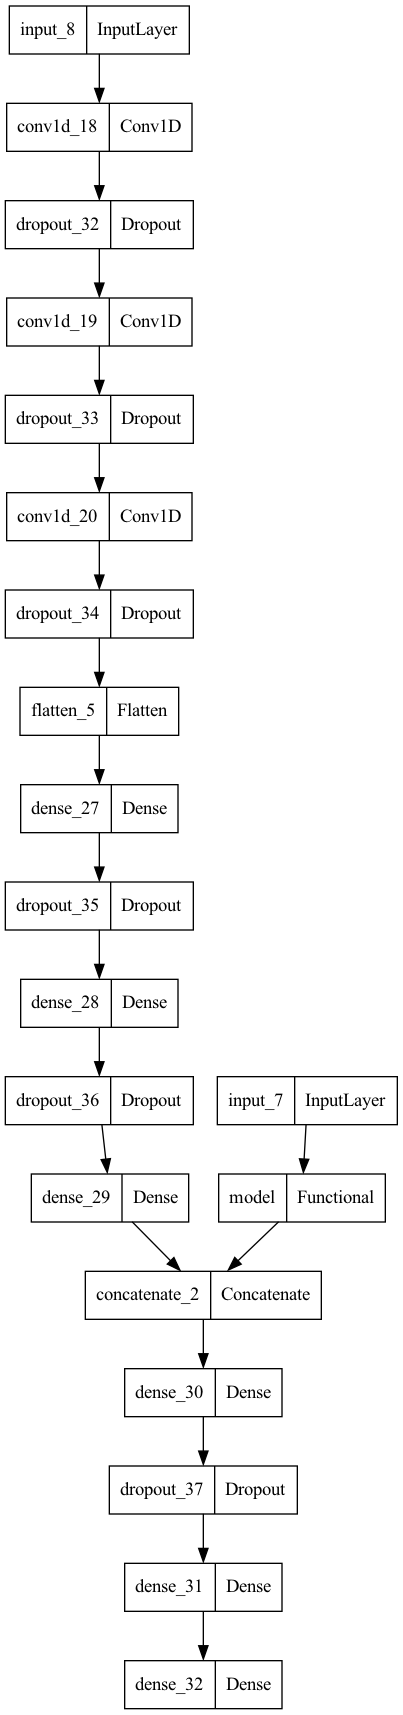

In [48]:
from tensorflow.keras.utils import plot_model

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['binary_accuracy'])

model.load_weights(weights_file_big)

model.summary()

plot_model(model, to_file="model.png")

In [45]:
history = model.fit(x=[x_train_img, x_train_hc], y=y_train_img,
    validation_data=([x_val_img, x_val_hc], y_val_img),
    epochs=10, batch_size=batch_size, callbacks=[great_callback])

Epoch 1/10
750/750 [==============================] - 290s 385ms/step - loss: 0.1705 - binary_accuracy: 0.9313 - val_loss: 0.1903 - val_binary_accuracy: 0.9327
Epoch 2/10
750/750 [==============================] - 279s 373ms/step - loss: 0.1513 - binary_accuracy: 0.9391 - val_loss: 0.1952 - val_binary_accuracy: 0.9323
Epoch 3/10
750/750 [==============================] - 281s 375ms/step - loss: 0.1501 - binary_accuracy: 0.9391 - val_loss: 0.1935 - val_binary_accuracy: 0.9320
Epoch 4/10
750/750 [==============================] - 282s 376ms/step - loss: 0.1490 - binary_accuracy: 0.9390 - val_loss: 0.2027 - val_binary_accuracy: 0.9360
Epoch 5/10
750/750 [==============================] - 280s 373ms/step - loss: 0.1488 - binary_accuracy: 0.9402 - val_loss: 0.1984 - val_binary_accuracy: 0.9370
Epoch 6/10
750/750 [==============================] - 280s 374ms/step - loss: 0.1481 - binary_accuracy: 0.9398 - val_loss: 0.1981 - val_binary_accuracy: 0.9260
Epoch 7/10
750/750 [====================

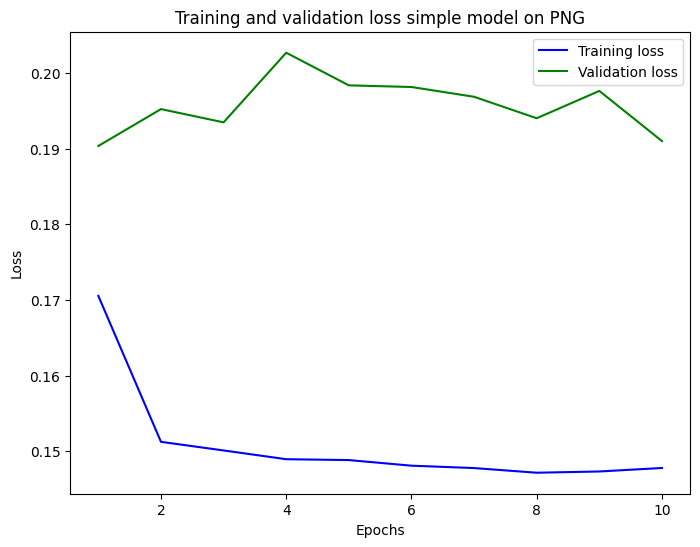

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# pdf = PdfPages("../images/loss_simple_png.pdf")
fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure(figsize=(8, 5))
# ax.axis('equal')
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss simple model on PNG')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
# pdf.savefig(fig)
# pdf.close()
plt.show()

Accuracy with clean data is 97%. With noised data - 89.23%

In [59]:
score = model.evaluate([x_test_img, x_test_hc], y_test_img)
print("Simple CNN test loss:", score[0])
print("Simple CNN test accuracy:", score[1])

94/94 [==============================] - 31s 325ms/step - loss: 0.6097 - binary_accuracy: 0.8923
Simple CNN test loss: 0.6096669435501099
Simple CNN test accuracy: 0.8923333287239075


In [ ]:
train_data_img = tf.data.Dataset.from_tensor_slices((x_train_img, y_train_img))
val_data_img = tf.data.Dataset.from_tensor_slices((x_val_img, y_val_img))
test_data_img = tf.data.Dataset.from_tensor_slices((x_test_img, y_test_img))

batch_size = 32

train_ds = train_data_img.cache().batch(batch_size).prefetch(buffer_size=100)
validation_ds = val_data_img.batch(batch_size).prefetch(buffer_size=100)
test_ds = test_data_img.batch(batch_size).prefetch(buffer_size=100)

In [36]:
weights_file_hc = '../weights_xception/rnn_weights.h5'
callback_hc = ModelCheckpoint(weights_file_hc, mode='max', save_best_only=True)

# rnn
model_hc = Sequential()
model_hc.add(Conv1D(filters=256, kernel_size=20, activation='tanh', padding='same', input_shape=x_train_hc.shape[-2:]))
model_hc.add(Dropout(0.1))
model_hc.add(Conv1D(filters=128, kernel_size=20, activation='tanh', padding='same'))
model_hc.add(Dropout(0.1))
model_hc.add(Conv1D(filters=64, kernel_size=20, activation='tanh', padding='same'))
model_hc.add(Flatten())
model_hc.add(Dense(1024, activation='tanh'))
model_hc.add(Dropout(0.2))
model_hc.add(Dense(512, activation='tanh'))
model_hc.add(Dropout(0.1))
model_hc.add(Dense(128, activation='tanh'))
model_hc.add(Dropout(0.1))
model_hc.add(Dense(1, activation='sigmoid'))

#compile model using accuracy to measure model performance
model_hc.compile(optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()])

# model_hc.load_weights(weights_file_hc)

In [37]:
#train the model
history_hc = model_hc.fit(x_train_hc, y_train_hc,
            validation_data=(x_val_hc, y_val_hc),
            batch_size=64, epochs=30,
            callbacks=[callback_hc])

Epoch 1/30
375/375 [==============================] - 16s 41ms/step - loss: 0.5118 - binary_accuracy: 0.7606 - val_loss: 0.6311 - val_binary_accuracy: 0.6003
Epoch 2/30
375/375 [==============================] - 14s 38ms/step - loss: 0.4740 - binary_accuracy: 0.7773 - val_loss: 0.6561 - val_binary_accuracy: 0.5960
Epoch 3/30
375/375 [==============================] - 13s 35ms/step - loss: 0.4585 - binary_accuracy: 0.7886 - val_loss: 0.6571 - val_binary_accuracy: 0.6933
Epoch 4/30
375/375 [==============================] - 13s 35ms/step - loss: 0.4520 - binary_accuracy: 0.7915 - val_loss: 0.7220 - val_binary_accuracy: 0.6847
Epoch 5/30
375/375 [==============================] - 13s 35ms/step - loss: 0.4454 - binary_accuracy: 0.7960 - val_loss: 0.6403 - val_binary_accuracy: 0.6883
Epoch 6/30
375/375 [==============================] - 13s 35ms/step - loss: 0.4349 - binary_accuracy: 0.8045 - val_loss: 0.7127 - val_binary_accuracy: 0.6767
Epoch 7/30
375/375 [==============================] 

KeyboardInterrupt: 

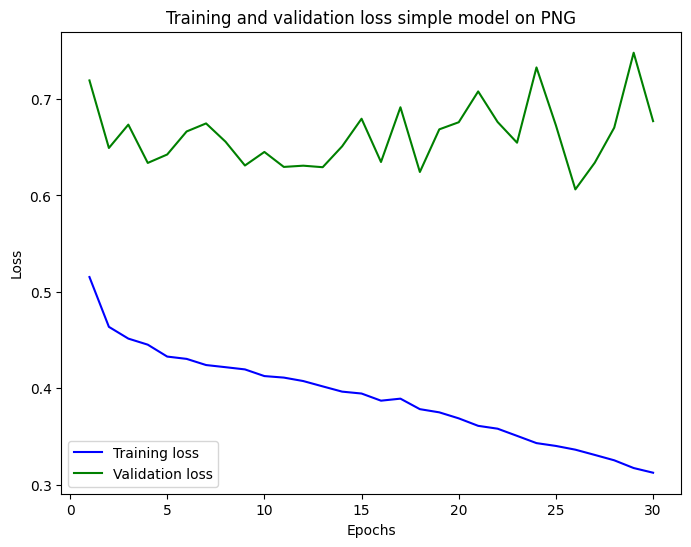

In [33]:
loss = history_hc.history['loss']
val_loss = history_hc.history['val_loss']
epochs = range(1, len(loss) + 1)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(epochs, loss, 'b', label='Training loss')
ax.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss simple model on PNG')
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
plt.show()

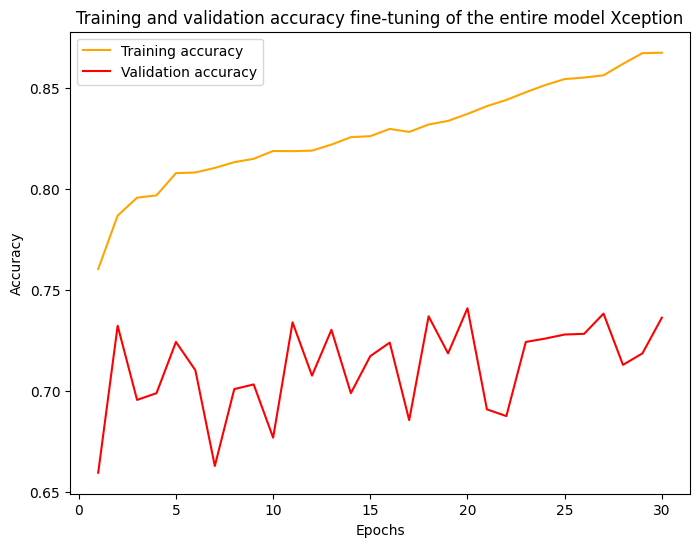

In [34]:
loss = history_hc.history['binary_accuracy']
val_loss = history_hc.history['val_binary_accuracy']
epochs = range(1, len(loss) + 1)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(epochs, loss, color = 'orange', label='Training accuracy')
ax.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy fine-tuning of the entire model Xception')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend()
plt.show()

In [35]:
score = model_hc.evaluate(x_test_hc, y_test_hc)
print("Simple rnn test loss:", score[0])
print("Simple rnn test accuracy:", score[1])

94/94 [==============================] - 0s 3ms/step - loss: 0.3668 - binary_accuracy: 0.8347
Simple rnn test loss: 0.36678600311279297
Simple rnn test accuracy: 0.8346666693687439


In [ ]:
from keras import backend as K

inp = model_hc.input                                           # input placeholder
outputs = [layer.output for layer in model_hc.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

# Testing
input_shape=x_train_hc.shape[-2:]
test = np.random.random(input_shape)[np.newaxis,...]
layer_outs = [func([test]) for func in functors]
print(layer_outs)

[[array([[-0.9629658 ,  0.96298385, -0.96347195,  0.9636778 , -0.96322596,
         0.9629503 ,  0.9634506 ,  0.9633366 ,  0.9635843 ,  0.95850503]],
      dtype=float32)], [array([[0.9877598 , 0.9910485 , 0.9907734 , 0.9897851 , 0.98732495]],
      dtype=float32)], [array([[0.9784226]], dtype=float32)], [array([[0.2958442]], dtype=float32)]]


In [ ]:
zero = 0
one = 0

for i in y_test_hc:
    if i == 0:
        zero += 1
    else:
        one += 1

print(zero, one)

2666 334
